**Location**: San Diego, CA **Objective**: Decompose the latent drivers of Al Pastor consumption.

Welcome to San Diego! You are attending **NeurIPS 2025**. Between the Deep Learning keynotes and the poster sessions, there is one variable that dominates the conference dynamics: **The hunger for Tacos.**

We suspect that local weather plays a role (San Diegans are notoriously sensitive to the cold), but it implies only part of the story. There are hidden rhythms—weekly cycles, trend shifts, and random shocks—that govern the lines at the taqueria.

In this notebook, we will build a **Bayesian Structured Time Series (STS)** model using `RxInfer.jl` to predict this demand.

## 1. Setup & Data Generation
We load the necessary libraries, including `ClosedFormExpectations` and `ExponentialFamilyProjection` for the twist model.

In [2]:
using RxInfer, LinearAlgebra, Statistics, Plots, StableRNGs
using HTTP, JSON3, DataFrames, CSV, Dates, Random, Distributions
using ClosedFormExpectations, ExponentialFamilyProjection, ExponentialFamily

# Professional plotting theme
theme(:wong)

# Reproducibility
rng = StableRNG(42)

println("Libraries loaded. Preparation for consumption initiated.")

Libraries loaded. Preparation for consumption initiated.


### The Data: "World Knowledge" Logic
We generate a synthetic **Taco Demand Index** based on real weather history.

📡 Fetching Real San Diego Weather...
Generating Demand using World Knowledge Logic...
Data Ready. Training on 987 days.


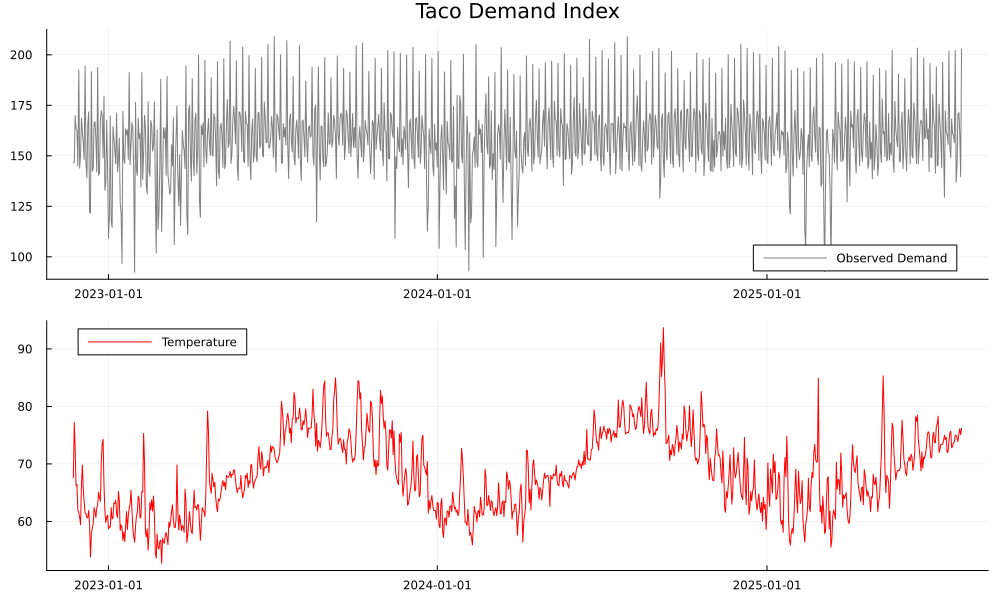

In [3]:
const LAT = 32.7157
const LON = -117.1611
const START_DATE = Date(today()) - Year(3)
const ARCHIVE_END_DATE = Date(today())

function fetch_real_weather()
    println("📡 Fetching Real San Diego Weather...")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = Dict(
        "latitude" => LAT, "longitude" => LON,
        "start_date" => string(START_DATE), "end_date" => string(ARCHIVE_END_DATE),
        "daily" => "temperature_2m_max,rain_sum",
        "temperature_unit" => "fahrenheit", "precipitation_unit" => "inch",
        "timezone" => "America/Los_Angeles"
    )
    query_str = join(["$k=$v" for (k,v) in params], "&")
    try
        resp = HTTP.get("$url?$query_str")
        data = JSON3.read(resp.body)
        return DataFrame(
            Date = Date.(String.(data.daily.time)),
            Max_Temp_F = Float64.(data.daily.temperature_2m_max),
            Rain_Inches = Float64.(data.daily.rain_sum)
        )
    catch e
        println("API Error."); rethrow(e)
    end
end

# Feel free to change the logic or use real data (please share!)
function calculate_taco_demand(df::DataFrame)
    println("Generating Demand using World Knowledge Logic...")
    scores = Float64[]
    for row in eachrow(df)
        d = 150.0
        # Patio Curve
        temp_factor = clamp(1.0 - (abs(row.Max_Temp_F - 72.0)/100.0)^1.5, 0.3, 1.0)
        d *= temp_factor
        # Rain
        rain = row.Rain_Inches
        if rain > 0.5; d -= 40.0; elseif rain > 0.2; d -= 25.0; elseif rain > 0.05; d -= 15.0; end
        # Calendar
        if dayofweek(row.Date) == 2; d += 50.0; end 
        if dayofweek(row.Date) in [5, 6]; d += 20.0;
        elseif dayofweek(row.Date) == 7; d += 12.0;
        end
        
        d += randn() * 5.0 
        push!(scores, clamp(d, 20.0, 250.0))
    end
    df.Taco_Demand_Index = round.(scores, digits=1)
    return df
end

df_weather_history = fetch_real_weather()
df_history = calculate_taco_demand(deepcopy(df_weather_history))
demand = df_history.Taco_Demand_Index
temperature = df_history.Max_Temp_F
dates = df_history.Date

# Split Train/Test
n_total = length(demand)
n_predict = Int(round(n_total * 0.1)) # Holdout 10% of data
n_train = n_total - n_predict

println("Data Ready. Training on $n_train days.")
p1 = plot(dates[1:n_train], demand[1:n_train], label="Observed Demand", title="Taco Demand Index", color=:gray)
p2 = plot(dates[1:n_train], temperature[1:n_train], label="Temperature", color=:red)
plot(p1, p2, layout=(2,1), size=(1000, 600))

## 2. The Twist STS Model
We implement a **Twist** model that combines State-Space dynamics with Regressors using a projection method to handle Poisson observations. This involves projecting the posterior of the rate `lambda` to a Gamma distribution.

In [4]:
# Model Constants
D = 6
H_vec = [1.0, 1.0, 0.0, 1.0, 0.0, 1.0] 

# Transition Matrix Logic
function transition(F)
    FT = eltype(F)
    M = zeros(FT, 6, 6)
    M[1,1] = one(FT)
    M[2,2] = F[1]; M[2,3] = F[2]; M[3,2] = -F[2]; M[3,3] = F[1]
    M[4,4] = F[3]; M[4,5] = F[4]; M[5,4] = -F[4]; M[5,5] = F[3]
    M[6,6] = F[5]
    return M
end

var_rate = 1e3

@model function rxsts_twist_poisson(H, X, y, R, priors)
    # Priors
    β     ~ priors[:β]
    Q     ~ Wishart(priors[:Q].df, priors[:Q].S)
    η     ~ MvNormalMeanPrecision(mean(priors[:η]), Q)
    zprev ~ priors[:z0]
    F     ~ priors[:F]
    
    # Auxiliary precisions for the independent bridges
    γ_aux_state ~ GammaShapeRate(0.01, var_rate)
    γ_aux_reg   ~ GammaShapeRate(0.01, var_rate)

    for t in eachindex(y)
        
        z₁[t] ~ ContinuousTransition(zprev, F, diageye(D))
        z₂[t] ~ R*η
        z[t] ~ z₁[t] + z₂[t]

        # Separate components
        mu_state[t] ~ dot(H, z[t])
        mu_reg[t]   ~ dot(X[t], β)

        # Bridge: Connect BOTH Gaussian predictions to the SAME lambda[t]
        lambda[t] ~ Uninformative()
        
        # Path 1: State-Space -> lambda
        mu_state[t] ~ NormalMeanPrecision(lambda[t], γ_aux_state)
        
        # Path 2: Regressor -> lambda
        mu_reg[t] ~ NormalMeanPrecision(lambda[t], γ_aux_reg)
        
        # Observation
        y[t] ~ Poisson(lambda[t])

        zprev = z[t]
    end
end

@constraints function rxsts_twist_constraints()
    # Factorization
    q(z, z₁, z₂, zprev, F, Q, η, mu_state, mu_reg, β, lambda, γ_aux_state, γ_aux_reg) = 
        q(z, z₁, z₂, zprev)q(F)q(Q)q(η)q(mu_state)q(mu_reg)q(β)q(lambda)q(γ_aux_state)q(γ_aux_reg)
    
    # Projection for lambda
    q(lambda) :: ProjectedTo(Gamma, parameters=ProjectionParameters(strategy=ClosedFormStrategy()))
end

@meta function rxsts_twist_meta()
    ContinuousTransition() -> CTMeta(transition)
end

rxsts_twist_meta (generic function with 1 method)

### Inference
We prepare the priors, matrices, and data for inference.

In [5]:
R_mat = [
    1     0    0    0
    0     1    0    0
    0     0    0    0
    0     0    1    0
    0     0    0    0
    0     0    0    1
]

priors = Dict(
    :β => MvNormalMeanPrecision(ones(1), diageye(1)),
    :z0 => MvNormalMeanPrecision(ones(D), diageye(D)),
    :F => MvNormalMeanPrecision([1.0, 1.0, 1.0, 1.0, 1.0], diageye(5)),
    :Q => Wishart(4, diagm([1.0, 1.0, 1.0, 1.0])),
    :η => MvNormalMeanPrecision(zeros(4), diageye(4))
)

@initialization function rxsts_twist_init(priors)
    q(F)     = priors[:F]
    q(Q)     = priors[:Q]
    q(η)     = priors[:η]
    μ(β)     = priors[:β]
    μ(zprev) = priors[:z0]
    μ(z)     = priors[:z0]
    
    # Init for new vars
    q(γ_aux_state) = GammaShapeRate(1.0, var_rate)
    q(γ_aux_reg)   = GammaShapeRate(1.0, var_rate)
    q(lambda)      = GammaShapeScale(10.0, 1.0) 
    q(mu_state)    = NormalMeanVariance(1.0, 10.0)
    q(mu_reg)      = NormalMeanVariance(1.0, 10.0)
end

# Prepare data
# Convert Taco Demand to Integers for Poisson
y_raw = round.(Int, demand)

n_predict = Int(round(length(y_raw)*0.1))
y_masked = Vector{Union{Missing, Int}}(undef, length(y_raw))
y_masked[1:end-n_predict] = y_raw[1:end-n_predict]
y_masked[end-n_predict+1:end] .= missing

X_mat = [[temp] for temp in temperature] 

println("Running inference on Combined Twist Model...")
results = infer(
    model = rxsts_twist_poisson(H=H_vec, X=X_mat, R=R_mat, priors=priors),
    data = (y = y_masked,),
    constraints = rxsts_twist_constraints(),
    meta = rxsts_twist_meta(),
    initialization = rxsts_twist_init(priors),
    returnvars = KeepLast(),
    iterations = 10,
    showprogress = true,
    options = (limit_stack_depth = 500,),
)

println("Inference complete.")

Running inference on Combined Twist Model...


┌ Warning: 'Gamma' and 'GammaShapeScale' without keywords are constructed with parameters (Shape, Scale).
└ @ RxInfer /Users/mykola/.julia/packages/RxInfer/sUzDE/src/model/graphppl.jl:266
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Inference complete.


### Visualization
We visualize the estimated Poisson rates against the observed Taco demand.

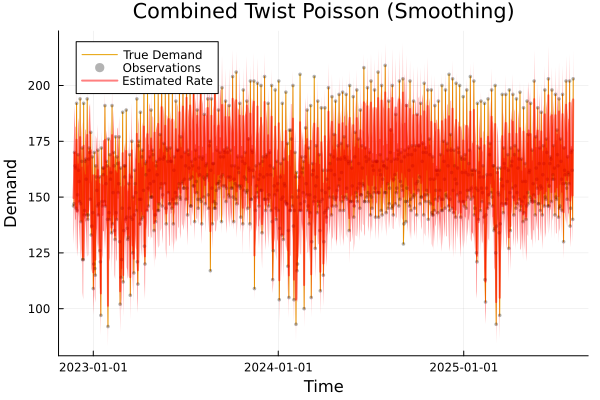

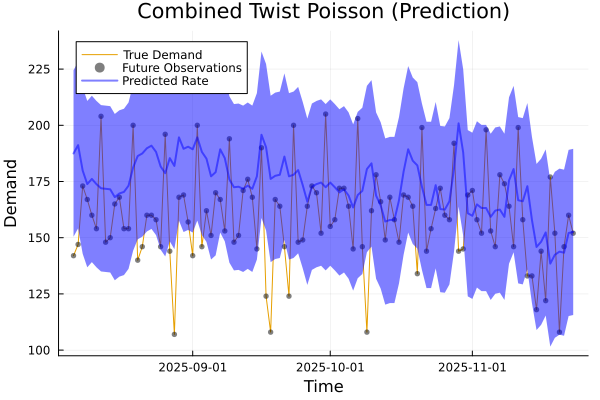

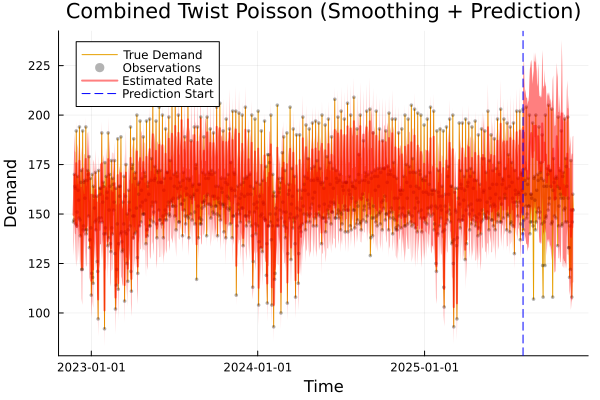

In [6]:
# Analyze Results
lambda_res = results.posteriors[:lambda]
lambda_mean = mean.(lambda_res)
lambda_std = std.(lambda_res)

# 1. Smoothing Plot
idx_smooth = 1:(length(y_raw) - n_predict)
p_smooth = plot(dates[idx_smooth], y_raw[idx_smooth], label = "True Demand", legend = :topleft, title = "Combined Twist Poisson (Smoothing)", xlabel = "Time", ylabel = "Demand")
scatter!(p_smooth, dates[idx_smooth], y_raw[idx_smooth], label = "Observations", markersize=2, color=:black, alpha=0.3)
plot!(p_smooth, dates[idx_smooth], lambda_mean[idx_smooth], ribbon = 2 .* lambda_std[idx_smooth], label = "Estimated Rate", alpha = 0.5, color=:red, lw=2)
display(p_smooth)

# 2. Prediction Plot
idx_predict = (length(y_raw) - n_predict + 1):length(y_raw)
p_predict = plot(dates[idx_predict], y_raw[idx_predict], label = "True Demand", legend = :topleft, title = "Combined Twist Poisson (Prediction)", xlabel = "Time", ylabel = "Demand")
scatter!(p_predict, dates[idx_predict], y_raw[idx_predict], label = "Future Observations", markersize=3, color=:black, alpha=0.5)
plot!(p_predict, dates[idx_predict], lambda_mean[idx_predict], ribbon = 2 .* lambda_std[idx_predict], label = "Predicted Rate", alpha = 0.5, color=:blue, lw=2)
display(p_predict)

# Total Plot
p_total = plot(dates, y_raw, label = "True Demand", legend = :topleft, title = "Combined Twist Poisson (Smoothing + Prediction)", xlabel = "Time", ylabel = "Demand")
scatter!(p_total, dates, y_raw, label = "Observations", markersize=2, color=:black, alpha=0.3)
plot!(p_total, dates, lambda_mean, ribbon = 2 .* lambda_std, label = "Estimated Rate", alpha = 0.5, color=:red, lw=2)
vline!(p_total, [dates[length(y_raw) - n_predict]], label = "Prediction Start", linestyle = :dash, color = :blue)
display(p_total)